In [1]:
import pandas as pd
import numpy as np
import sklearn.base
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBClassifier
import imblearn
from collections import Counter
from imblearn.pipeline import Pipeline
import hyperopt
import matplotlib.pyplot as plt
from openpyxl.workbook import Workbook

In [2]:
#задание количества выводимых на экран строк
pd.options.display.max_rows = 96
#создание датафрейма
df = pd.read_csv("data.csv")
#вывели типы данных, X - входные данные (95 колонок), y - выходные данные (1 колонка)
print(df.dtypes)

Bankrupt?                                                     int64
 ROA(C) before interest and depreciation before interest    float64
 ROA(A) before interest and % after tax                     float64
 ROA(B) before interest and depreciation after tax          float64
 Operating Gross Margin                                     float64
 Realized Sales Gross Margin                                float64
 Operating Profit Rate                                      float64
 Pre-tax net Interest Rate                                  float64
 After-tax net Interest Rate                                float64
 Non-industry income and expenditure/revenue                float64
 Continuous interest rate (after tax)                       float64
 Operating Expense Rate                                     float64
 Research and development expense rate                      float64
 Cash flow rate                                             float64
 Interest-bearing debt interest rate            

In [3]:
#вывод датафрейма полностью
# pd.set_option('display.max_rows', None)
df

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


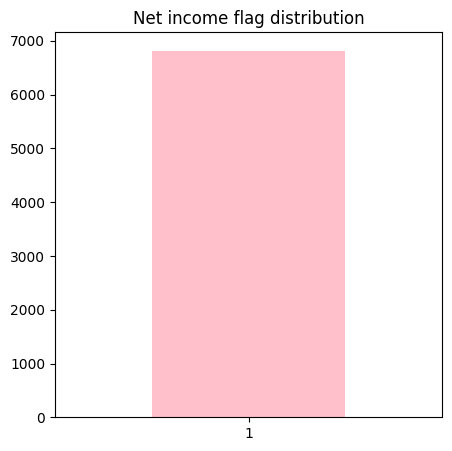

AttributeError: 'tuple' object has no attribute 'savefig'

In [23]:
fig, ax = plt.subplots(figsize=(5,5))
df[' Net Income Flag'].value_counts().plot.bar(y='Net Income Flag', rot=0, color = 'pink')
plt.title("Net income flag distribution")
plt.show()
fig.savefig("net income flag.png", dpi = 300)
print(df[' Net Income Flag'].value_counts())

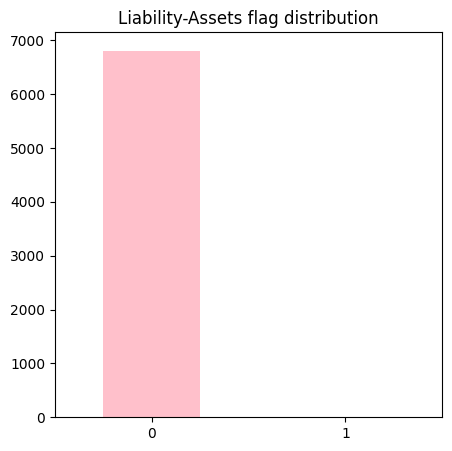

0    6811
1       8
Name:  Liability-Assets Flag, dtype: int64


In [28]:
fig, ax = plt.subplots(figsize=(5,5))
df[' Liability-Assets Flag'].value_counts().plot.bar(y='Net Income Flag', rot=0, color = 'pink')
plt.title("Liability-Assets flag distribution")
plt.show()
fig.savefig("Liability-Assets flag.png", dpi = 300)
print(df[' Liability-Assets Flag'].value_counts())

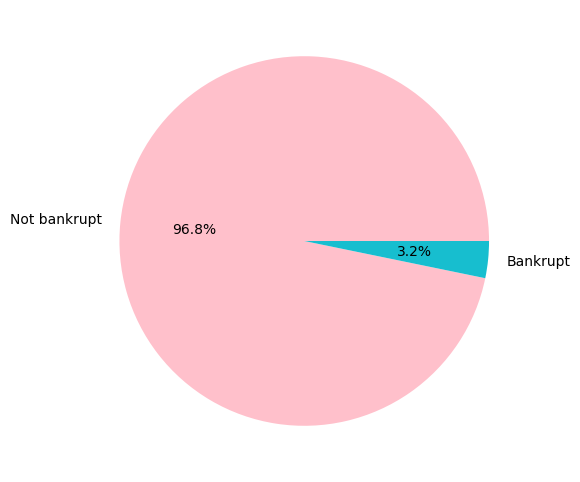

In [39]:
column = df.groupby(['Bankrupt?']).count().iloc[:,0]
fig, ax = plt.subplots(figsize=(6,6))
plt.pie(column, labels = ['Not bankrupt','Bankrupt'], colors = ['Pink', 'tab:cyan'], autopct='%.1f%%')
plt.show()
fig.savefig("diagramm.png", dpi = 300)

ГРАФИК

In [4]:
dfnew = np.array(df.loc[:, df.columns != 'Bankrupt?']) # образуются массивы по каждой строке входных данных
#print(dfnew)
#транспонируем датафрейм, чтобы строка состояла из элементов одного вида входных данных (то есть  данном случае строке соответсвует столбец исходного датафрейма)
dfnew_transposed = dfnew.T
#print(dfnew_transposed)
#статистические характеристики
mean = []
std = []
median = []
max = []
min = []
#на выдохе необходимы строки, чтобы далее сделать датафрейм стат.характеристик
for (i,j) in enumerate(dfnew_transposed): #i - индекс вида входных данных , j - значения
    mean.append(j.mean())
    std.append(j.std())
    max.append(j.max())
    min.append(j.min())
    median.append(np.median(j))
#print(mean)
# print(std)
# print(median)
# print(max)
# print(min)

newcolumns = df.drop('Bankrupt?', axis=1)

#convert lists into a single list
data = []
data.append(newcolumns.columns)
data.append(mean)
data.append(std)
data.append(median)
data.append(max)
data.append(min)

#convert list into DataFrame
table1 = pd.DataFrame(data).transpose()
table1.columns =["Столбец данных", "Матожидание", "Станд.откл.", "Медиана", "Максимум", "Минимум"]
#вывели таблицу статистических характеристик по столбцам
table1.to_excel("stat.xlsx")
table1

,Столбец данных,Матожидание,Станд.откл.,Медиана,Максимум,Минимум
0,ROA(C) before interest and depreciation befor...,0.50518,0.060681,0.502706,1.0,0.0
1,ROA(A) before interest and % after tax,0.558625,0.065615,0.559802,1.0,0.0
2,ROA(B) before interest and depreciation after...,0.553589,0.06159,0.552278,1.0,0.0
3,Operating Gross Margin,0.607948,0.016933,0.605997,1.0,0.0
4,Realized Sales Gross Margin,0.607929,0.016915,0.605976,1.0,0.0
5,Operating Profit Rate,0.998755,0.013009,0.999022,1.0,0.0
6,Pre-tax net Interest Rate,0.79719,0.012868,0.797464,1.0,0.0
7,After-tax net Interest Rate,0.809084,0.0136,0.809375,1.0,0.0
8,Non-industry income and expenditure/revenue,0.303623,0.011163,0.303525,1.0,0.0
9,Continuous interest rate (after tax),0.781381,0.012678,0.781635,1.0,0.0


In [4]:
#разделяем данные на Х и у (почти в каждой ячейке для удобства)
X = df.drop('Bankrupt?', axis=1) #входные данные получаем удалением столбца выходных данных из исходного датафрейма
y = df.loc[:,'Bankrupt?'] #выходные данные - столбец 'Bankrupt?'

#воспользуемся моделью, которая, в свою очередь, яляется реализацией библиотеки машинного обучения scikit-learn для XGBoost-классификации (экстремальный градиентный бустинг). Модель носит название XGBClassifier. Мы начнем применять ее без изменения входных параметров
model = XGBClassifier()
#Данная модель будет являться одним из параметром для кросс-валидации. Далее определим еще один параметр - cv, в нашем случае возьмем в качестве этого параметра утилиту RepeatedKFold. Она представляет собой
#следующий метод будет использоваться для кросс-валидации, включает в себя следующие параметры: n_splits - делит исходную выборку на подвыборки, под каждым из десяти номеров закреплена одна выборка, которая не меняется при многократном запуске ячейки; n_repeats - количество повторений обучения каждой подвыборки;
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
#n_scores - результаты кросс-валидации (в каком-то смысле значения вероятностей, сами по себе ничего не значат, выводы производятся исключетельно относительно друг друга), выводит 3 значения. Для нас предпочтительнее, чтобы каждое значение было близко к единице. Дальнейшие методы работы с данными, переборы параметров рассмотрены и выполнены именно для такого результата. Здесь параметр n_jobs означает количество ядер процесса, которые будут использоваться при обучении данных. -1 - все ядра.
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = -1)

#вышеупомянутые n_scores выведем в формате среднего значения, в скобках укажем стандартное отклонение, в пределах которого может колебаться результат
for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 25.888 (2.743)
score_time: 0.040 (0.053)
test_accuracy: 0.970 (0.006)
test_precision: 0.601 (0.134)
test_recall: 0.259 (0.089)
test_f1: 0.352 (0.093)


In [5]:
#вычислим количество элементов каждого класса
print((df.loc[:,'Bankrupt?'] == 1).sum())
print((df.loc[:,'Bankrupt?'] == 0).sum())
#выравниваем вклад в функцию потерь позитивных и негативных данных (в нашем случае позитивными являются данные 1, то есть объявление
scale_pos_weight = (df.loc[:,'Bankrupt?'] == 0).sum()/(df.loc[:,'Bankrupt?'] == 1).sum()
print(scale_pos_weight)

220
6599
29.995454545454546


In [6]:
#Выведем повторно метрики после выравнивания вклада в функцию потерь позитивных и негативных данных
X = df.drop('Bankrupt?', axis=1)
y = df.loc[:,'Bankrupt?']

model = XGBClassifier(scale_pos_weight = scale_pos_weight)
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = -1)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 17.578 (1.194)
score_time: 0.022 (0.003)
test_accuracy: 0.969 (0.006)
test_precision: 0.525 (0.088)
test_recall: 0.434 (0.110)
test_f1: 0.469 (0.087)


In [7]:
#увеличим scale_pos_weight
model = XGBClassifier(scale_pos_weight = 50)
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall','f1'], cv = cv, n_jobs = -1)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 17.308 (1.490)
score_time: 0.022 (0.004)
test_accuracy: 0.968 (0.007)
test_precision: 0.512 (0.102)
test_recall: 0.427 (0.115)
test_f1: 0.460 (0.095)


In [5]:
#увеличим scale_pos_weight
model = XGBClassifier(scale_pos_weight = 1000)
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = -1)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 20.150 (2.314)
score_time: 0.021 (0.003)
test_accuracy: 0.965 (0.006)
test_precision: 0.460 (0.076)
test_recall: 0.501 (0.111)
test_f1: 0.472 (0.069)


In [6]:
#увеличим scale_pos_weight
model = XGBClassifier(scale_pos_weight = 10000)
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = -1)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 20.924 (1.493)
score_time: 0.023 (0.006)
test_accuracy: 0.958 (0.006)
test_precision: 0.384 (0.071)
test_recall: 0.524 (0.104)
test_f1: 0.438 (0.067)


In [7]:
X1, y1 = imblearn.over_sampling.SMOTE().fit_resample(X,y)

In [8]:
print(Counter(y))
print(Counter(y1))

Counter({0: 6599, 1: 220})
Counter({1: 6599, 0: 6599})


In [9]:
model = XGBClassifier()
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
n_scores = cross_validate(model, X1, y1, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = -1)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 71.100 (3.970)
score_time: 0.086 (0.092)
test_accuracy: 0.989 (0.003)
test_precision: 0.980 (0.006)
test_recall: 0.998 (0.002)
test_f1: 0.989 (0.003)


In [10]:
model = XGBClassifier()
smote = imblearn.over_sampling.SMOTE()
pipeline = Pipeline(steps = [('smote', smote), ('model', model)])

cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
n_scores = cross_validate(pipeline, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = -1)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 76.235 (2.918)
score_time: 0.044 (0.058)
test_accuracy: 0.966 (0.006)
test_precision: 0.469 (0.089)
test_recall: 0.505 (0.110)
test_f1: 0.480 (0.083)


In [11]:
model = XGBClassifier()
smote = imblearn.over_sampling.SMOTE(sampling_strategy = 0.5)
pipeline = Pipeline(steps = [('smote', smote), ('model', model)])

cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
n_scores = cross_validate(pipeline, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = -1)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 51.004 (3.413)
score_time: 0.031 (0.048)
test_accuracy: 0.967 (0.007)
test_precision: 0.498 (0.085)
test_recall: 0.489 (0.107)
test_f1: 0.488 (0.081)


In [12]:
model = XGBClassifier()
smote = imblearn.over_sampling.SMOTE(sampling_strategy = 0.9)
pipeline = Pipeline(steps = [('smote', smote), ('model', model)])

cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
n_scores = cross_validate(pipeline, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = -1)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 71.021 (7.100)
score_time: 0.033 (0.039)
test_accuracy: 0.965 (0.008)
test_precision: 0.461 (0.104)
test_recall: 0.492 (0.118)
test_f1: 0.470 (0.093)


In [13]:
#Создали класс, реализующий ансамль XGB-моделей, обученных на случайных сбалансированных подвыборках
class ResampledEnsemble(sklearn.base.BaseEstimator):

    def __init__(self, n_estimators = 100, zeros_ratio = 1, scale_pos_weight = 1, power = 1, ensemble_quantile = None):
        self.n_estimators = n_estimators
        self.classes_ = np.array([0,1])
        self.zeros_ratio = zeros_ratio
        self.scale_pos_weight = scale_pos_weight
        self.power = power
        #добавляем вместо среднего арифметического квантиль
        self.ensemble_quantile = ensemble_quantile

    def fit(self, X, y):
        self.estimators = []
        for i in range(self.n_estimators):
            ones = y == 1
            num_ones = ones.sum()
            zeros_indexes = np.where(np.logical_not(ones))[0]
            zeros_subsample = np.random.choice(zeros_indexes, size=int(num_ones*self.zeros_ratio), replace=False, p=None)
            final_indexes = np.concatenate([np.where(ones)[0], zeros_subsample])
            model = XGBClassifier(scale_pos_weight = self.scale_pos_weight)
            model.fit(X[final_indexes,:], y[final_indexes])
            self.estimators.append(model)
            #print("Fitting of model number {} is finished".format(i))
            if model.classes_[0] > model.classes_[1]:
                raise Exception("Wrong order of classes")

    def predict_proba(self, X):
        results = np.zeros([self.n_estimators, X.shape[0], 2]) #количество строк в иксе, количество столбцов по числу классов [0] и [1]
        for i in range(self.n_estimators):
            results[i,:,:] = self.estimators[i].predict_proba(X)
        if self.ensemble_quantile is None:
            ensemble_results = np.mean(results**self.power, axis = 0)
        else:
            ensemble_results = np.quantile(results**self.power, self.ensemble_quantile, axis = 0)
        row_sums =  np.sum(ensemble_results, axis = 1)
        return ensemble_results/row_sums[:, None]

    def predict(self, X):
        res_classes = np.zeros(X.shape[0])
        results = self.predict_proba(X)
        for i in range(X.shape[0]):
            res_classes[i] = self.classes_[np.argmax(results[i,:])]
        return res_classes

In [14]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsemble(n_estimators = 3)
model.fit(X,y)
print("Predicted classes:", model.predict(X[range(5),:]))
print("Predicted scores of classes:\n", model.predict_proba(X[range(5),:]))

Predicted classes: [1. 1. 1. 1. 1.]
Predicted scores of classes:
 [[2.93294589e-04 9.99706705e-01]
 [2.53053308e-02 9.74694669e-01]
 [1.83622042e-03 9.98163780e-01]
 [7.31686751e-03 9.92683132e-01]
 [2.47199535e-02 9.75280046e-01]]


In [17]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsemble(n_estimators = 5)
cv = RepeatedKFold(n_splits = 5, n_repeats = 3, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = -1)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 3.456 (0.373)
score_time: 0.072 (0.010)
test_accuracy: 0.857 (0.008)
test_precision: 0.171 (0.012)
test_recall: 0.891 (0.050)
test_f1: 0.287 (0.017)


In [18]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsemble(n_estimators = 100)
cv = RepeatedKFold(n_splits = 5, n_repeats = 3, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = -1)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 69.677 (5.697)
score_time: 1.543 (0.297)
test_accuracy: 0.859 (0.009)
test_precision: 0.173 (0.013)
test_recall: 0.892 (0.061)
test_f1: 0.289 (0.018)


Завести параметр, отвечающий за количество нулей. Сделать это число побольше
Лассо, рандомфорест сделать в другом юпитер ноутбуке

In [19]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsemble(n_estimators = 5, zeros_ratio = 15)
cv = RepeatedKFold(n_splits = 5, n_repeats = 3, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = -1)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 34.986 (1.131)
score_time: 0.094 (0.019)
test_accuracy: 0.969 (0.003)
test_precision: 0.529 (0.052)
test_recall: 0.440 (0.080)
test_f1: 0.477 (0.055)


In [20]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsemble(n_estimators = 100, zeros_ratio = 15)
cv = RepeatedKFold(n_splits = 5, n_repeats = 3, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = -1)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

KeyboardInterrupt: 

Объединение нескольких моделей в одну (взятие среднего арифметического/медианы/квантили)

In [21]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsemble(n_estimators = 5, zeros_ratio = 15, scale_pos_weight = 0.1)
cv = RepeatedKFold(n_splits = 5, n_repeats = 3, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall','f1'], cv = cv, n_jobs = 4)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 12.930 (1.104)
score_time: 0.058 (0.008)
test_accuracy: 0.971 (0.003)
test_precision: 0.611 (0.085)
test_recall: 0.254 (0.047)
test_f1: 0.356 (0.055)


In [40]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsemble(n_estimators = 5, zeros_ratio = 15, scale_pos_weight = 0.1)
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall'], cv = cv, n_jobs = -1)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 19.947 (0.655)
score_time: 0.059 (0.005)
test_accuracy: 0.968 (0.004)
test_precision: 0.511 (0.094)
test_recall: 0.421 (0.058)


In [35]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsemble(n_estimators = 5, zeros_ratio = 1, scale_pos_weight = 0.1)
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall','f1'], cv = cv, n_jobs = -1)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 2.273 (0.071)
score_time: 0.056 (0.006)
test_accuracy: 0.856 (0.009)
test_precision: 0.170 (0.010)
test_recall: 0.900 (0.058)


In [22]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsemble(n_estimators = 5, zeros_ratio = 20, scale_pos_weight = 1)
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = 4)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

KeyboardInterrupt: 

In [23]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsemble(n_estimators = 5, zeros_ratio = 20, scale_pos_weight = 55)
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = 4)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


test_recall стал больше 0.5

In [11]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsemble(n_estimators = 5, zeros_ratio = 20, scale_pos_weight = 55)
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall'], cv = cv, n_jobs = -1)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 48.848 (3.900)
score_time: 0.051 (0.007)
test_accuracy: 0.966 (0.006)
test_precision: 0.482 (0.084)
test_recall: 0.540 (0.117)


In [12]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsemble(n_estimators = 5, zeros_ratio = 20, scale_pos_weight = 55)
cv = RepeatedKFold(n_splits = 30, n_repeats = 1, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall'], cv = cv, n_jobs = -1)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 53.919 (4.107)
score_time: 0.027 (0.004)
test_accuracy: 0.966 (0.013)
test_precision: 0.489 (0.215)
test_recall: 0.552 (0.190)


In [17]:
#увеличим scale_pos_weight
model = XGBClassifier(scale_pos_weight = 1000)
cv = RepeatedKFold(n_splits = 30, n_repeats = 1, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall'], cv = cv, n_jobs = -1)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 16.906 (1.329)
score_time: 0.007 (0.001)
test_accuracy: 0.961 (0.014)
test_precision: 0.417 (0.185)
test_recall: 0.488 (0.191)


Заметили, что при использовании ансамблей (то есть при модификации модели) recall стал выше

Ниже пробуем работать со степенью. Возведем в степень выходное значение XGBoost-модели

In [ ]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsemble(n_estimators = 5, zeros_ratio = 20, scale_pos_weight = 55, power = 0.01)
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = 4)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

In [ ]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsemble(n_estimators = 5, zeros_ratio = 20, scale_pos_weight = 55, power = 0.001)
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = -1)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

In [32]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsemble(n_estimators = 5, zeros_ratio = 20, scale_pos_weight = 55, power = 0.001)
cv = RepeatedKFold(n_splits = 30, n_repeats = 1, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = -1)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 54.059 (4.448)
score_time: 0.029 (0.005)
test_accuracy: 0.966 (0.013)
test_precision: 0.487 (0.217)
test_recall: 0.552 (0.206)
test_f1: 0.485 (0.170)


In [ ]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsemble(n_estimators = 5, zeros_ratio = 20, scale_pos_weight = 55, power = 0.001)
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = -1)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

f1 - в каком-то смысле смесь test_precision и test_recall

In [8]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsemble(n_estimators = 5, zeros_ratio = 20, scale_pos_weight = 55, power = 0.001, ensemble_quantile = 0.25 )
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = -1)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 33.415 (1.216)
score_time: 0.065 (0.004)
test_accuracy: 0.966 (0.004)
test_precision: 0.477 (0.055)
test_recall: 0.536 (0.050)
test_f1: 0.501 (0.033)


In [9]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsemble(n_estimators = 5, zeros_ratio = 20, scale_pos_weight = 55, power = 0.001, ensemble_quantile = 0.5 )
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = -1)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 33.138 (1.046)
score_time: 0.065 (0.006)
test_accuracy: 0.966 (0.003)
test_precision: 0.474 (0.028)
test_recall: 0.532 (0.067)
test_f1: 0.499 (0.032)


Попробуем увеличить количество XGBoost-моделей в ансамбле

In [13]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsemble(n_estimators = 20, zeros_ratio = 20, scale_pos_weight = 55, power = 0.001, ensemble_quantile = 0.99)
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = -1)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 126.816 (4.642)
score_time: 0.314 (0.140)
test_accuracy: 0.967 (0.004)
test_precision: 0.487 (0.050)
test_recall: 0.528 (0.065)
test_f1: 0.503 (0.037)


Увеличим количество выборок для кроссвалидации

In [14]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsemble(n_estimators = 20, zeros_ratio = 20, scale_pos_weight = 55, power = 0.001, ensemble_quantile = 0.99)
cv = RepeatedKFold(n_splits = 30, n_repeats = 1, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = -1)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 218.197 (11.101)
score_time: 0.105 (0.017)
test_accuracy: 0.967 (0.011)
test_precision: 0.488 (0.199)
test_recall: 0.544 (0.182)
test_f1: 0.483 (0.156)


Уберем показатель степени, изменим квантиль

In [17]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsemble(n_estimators = 20, zeros_ratio = 20, scale_pos_weight = 55, ensemble_quantile = 0.5)
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = 4)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 83.300 (17.895)
score_time: 0.174 (0.031)
test_accuracy: 0.967 (0.005)
test_precision: 0.493 (0.058)
test_recall: 0.537 (0.071)
test_f1: 0.511 (0.044)


In [12]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsemble(n_estimators = 5, zeros_ratio = 20, scale_pos_weight = 55, power = 0.001, ensemble_quantile = 0.01)
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = -1)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 30.840 (1.057)
score_time: 0.064 (0.004)
test_accuracy: 0.966 (0.003)
test_precision: 0.474 (0.030)
test_recall: 0.540 (0.051)
test_f1: 0.503 (0.023)


Лассо, Support Vector Machine в новом ноутбуке

In [7]:
#Создали класс, реализующий ансамль XGB-моделей, обученных на случайных сбалансированных подвыборках с ансамблирующей функцией в виде модели машинного обучения
class SmartResampledEnsemble(sklearn.base.BaseEstimator):

    def __init__(self, n_estimators = 100, zeros_ratio = 1, scale_pos_weight = 1):
        self.n_estimators = n_estimators
        self.classes_ = np.array([0,1])
        self.zeros_ratio = zeros_ratio
        self.scale_pos_weight = scale_pos_weight

    def fit(self, X, y):
        self.estimators = []
        for i in range(self.n_estimators):
            ones = y == 1
            num_ones = ones.sum()
            zeros_indexes = np.where(np.logical_not(ones))[0]
            zeros_subsample = np.random.choice(zeros_indexes, size=int(num_ones*self.zeros_ratio), replace=False, p=None)
            final_indexes = np.concatenate([np.where(ones)[0], zeros_subsample])
            model = XGBClassifier(scale_pos_weight = self.scale_pos_weight)
            model.fit(X[final_indexes,:], y[final_indexes])
            self.estimators.append(model)
            #print("Fitting of model number {} is finished".format(i))
            if model.classes_[0] > model.classes_[1]:
                raise Exception("Wrong order of classes")
        results = np.zeros([X.shape[0], self.n_estimators])
        for i in range(self.n_estimators):
            results[:,i] = self.estimators[i].predict_proba(X)[:,1]
        self.ensemblingmodel = sklearn.tree.DecisionTreeClassifier()
        self.ensemblingmodel.fit(results, y)

    def predict_proba(self, X):
        results = np.zeros([X.shape[0], self.n_estimators])
        for i in range(self.n_estimators):
            results[:,i] = self.estimators[i].predict_proba(X)[:,1]
        ensemble_results = self.ensemblingmodel.predict_proba(results)
        return ensemble_results

    def predict(self, X):
        res_classes = np.zeros(X.shape[0])
        results = self.predict_proba(X)
        for i in range(X.shape[0]):
            res_classes[i] = self.classes_[np.argmax(results[i,:])]
        return res_classes

In [8]:
#sklearn.linear_model.LogisticRegression()
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = SmartResampledEnsemble(n_estimators = 3)
model.fit(X,y)
print("Predicted classes:", model.predict(X[range(5),:]))
print("Predicted scores of classes:\n", model.predict_proba(X[range(5),:]))

Predicted classes: [1. 1. 1. 1. 1.]
Predicted scores of classes:
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [9]:
#sklearn.linear_model.LogisticRegression()
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = SmartResampledEnsemble(zeros_ratio = 1.5, scale_pos_weight = 1)
cv = RepeatedKFold(n_splits = 10, n_repeats = 1, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = 4)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 61.439 (10.040)
score_time: 0.632 (0.105)
test_accuracy: 0.967 (0.007)
test_precision: 0.500 (0.138)
test_recall: 0.257 (0.086)
test_f1: 0.328 (0.076)


При zeros_ratio = 1.5, scale_pos_weight = 1:
test_accuracy: 0.967 (0.008)
test_precision: 0.500 (0.091)
test_recall: 0.530 (0.143)
test_f1: 0.502 (0.094)

In [5]:
#sklearn.tree.DecisionTreeClassifier()
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = SmartResampledEnsemble(n_estimators = 3)
model.fit(X,y)
print("Predicted classes:", model.predict(X[range(5),:]))
print("Predicted scores of classes:\n", model.predict_proba(X[range(5),:]))

Predicted classes: [1. 1. 1. 1. 1.]
Predicted scores of classes:
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [17]:
#sklearn.tree.DecisionTreeClassifier()
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = SmartResampledEnsemble()
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = 4)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 22.644 (4.276)
score_time: 0.563 (0.082)
test_accuracy: 0.961 (0.003)
test_precision: 0.387 (0.043)
test_recall: 0.369 (0.083)
test_f1: 0.374 (0.056)


При zeros_ratio = 0.1:
test_accuracy: 0.954 (0.002)
test_precision: 0.304 (0.042)
test_recall: 0.322 (0.075)
test_f1: 0.309 (0.043)

При данных по умолчанию:
test_accuracy: 0.967 (0.002)
test_precision: 0.492 (0.034)
test_recall: 0.350 (0.061)
test_f1: 0.405 (0.046)

In [7]:
#hyperopt
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

def hyperopt_train_test(params):
    clf = ResampledEnsemble(n_estimators = 100, **params)
    return sklearn.model_selection.cross_val_score(clf, X, y, scoring = "f1").mean()

params_space = {
    'zeros_ratio': hyperopt.hp.lognormal('zeros_ratio', 0, 1),
    'scale_pos_weight': hyperopt.hp.lognormal('scale_pos_weight', 0, 1),
    'ensemble_quantile': hyperopt.hp.uniform('ensemble_quantile', 0, 1)
}
def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': hyperopt.STATUS_OK}

trials = hyperopt.Trials() #объект для сбора информации об ошибках
best = hyperopt.fmin(f, params_space, algo = hyperopt.tpe.suggest, max_evals = 30 , trials = trials)
print(best)

 70%|███████   | 21/30 [35:17<29:52, 199.12s/trial, best loss: -0.37845393931688864]

C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\guzra\AppData\Local\Temp\ipykernel_12152\2514293604.py", line 19, in fit
    zeros_subsample = np.random.choice(zeros_indexes, size=int(num_ones*self.zeros_ratio), replace=False, p=None)
  File "mtrand.pyx", line 965, in numpy.random.mtrand.RandomState.cho

100%|██████████| 30/30 [1:02:46<00:00, 125.56s/trial, best loss: -0.4320612200987385]
{'ensemble_quantile': 0.6552370026090856, 'scale_pos_weight': 458.56301533797273, 'zeros_ratio': 13.677052309000633}


C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\guzra\AppData\Local\Temp\ipykernel_12152\2514293604.py", line 19, in fit
    zeros_subsample = np.random.choice(zeros_indexes, size=int(num_ones*self.zeros_ratio), replace=False, p=None)
  File "mtrand.pyx", line 965, in numpy.random.mtrand.RandomState.cho

In [8]:
def plot_trials(trials, param):
    f, ax = plt.subplots(1)
    xs = [t["tid"] for t in trials.trials]
    ys = [t['misc']['vals'][param] for t in trials.trials]
    zs = np.array([-t["result"]['loss'] for t in trials.trials])

    image = ax.scatter(xs, ys, c = zs, s = 100*zs+5, linewidth = 1.5 , alpha = 1)
    ax.set_xlabel('iteration', fontsize = 8)
    ax.set_ylabel(param, fontsize = 8)
    f.colorbar(image)

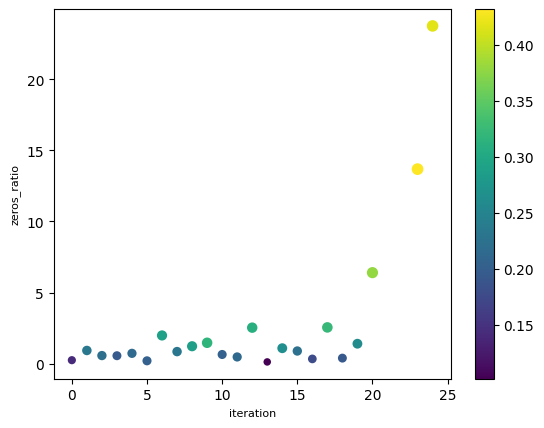

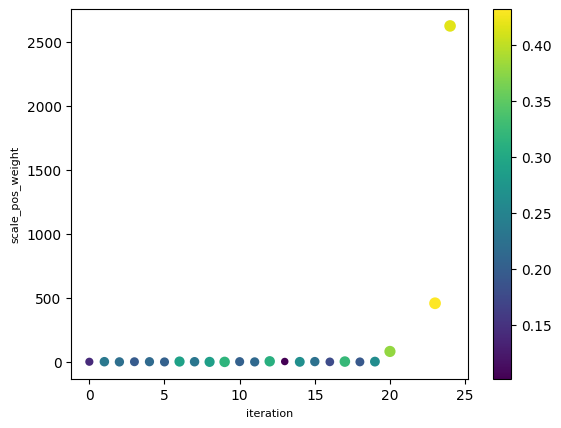

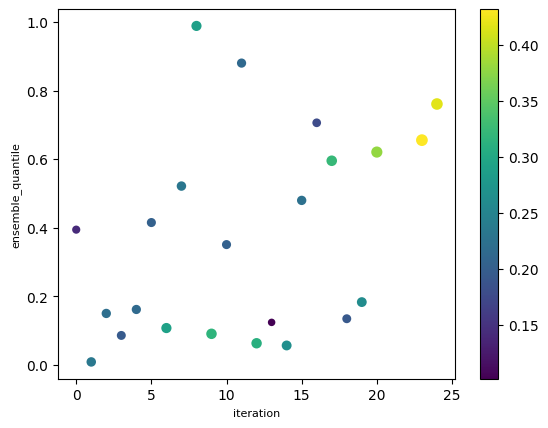

In [9]:
plot_trials(trials, 'zeros_ratio')
plot_trials(trials, 'scale_pos_weight')
plot_trials(trials, 'ensemble_quantile')